In [86]:
import numpy as np
import warnings
import time
import sklearn.metrics as skmetrics
from sklearn.calibration import calibration_curve, CalibrationDisplay
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore')

In [62]:
class Optimizer(object):

    def __init__(self, alpha, eta_decay_factor, optimizer_type):
        '''
        Arg(s):
            alpha : float
                initial learning rate 
            eta_decay_factor : float
                learning rate decay rate
            optimizer_type : str
                'gradient_descent',
                'stochastic_gradient_descent',
        '''

        self.__alpha = alpha
        self.__eta_decay_factor = eta_decay_factor
        self.__optimizer_type = optimizer_type

    def __compute_gradients(self, w, x, y, loss_func='logistic'):
        '''
        Returns the gradient of a loss function

        Arg(s):
            w : numpy[float32]
                d x 1 weight vector
            x : numpy[float32]
                d x N feature vector
            y : numpy[float32]
                1 x N groundtruth vector
            loss_func : str
                loss by default is 'logistic' only for the purpose of the assignment
        Returns:
            numpy[float32] : d x 1 gradients
        '''

        if loss_func == 'logistic':
            p = 1 / (1 + np.exp(-1 * y * np.matmul(w.T, x)))
            return -1 * np.mean(y * x * (1 - p), axis=1).reshape(w.shape)
        else:
            raise ValueError('Unupported loss function: {}'.format(loss_func))

    def __polynomial_decay(self, time_step):
        '''
        Computes the polynomial decay factor t^{-a}

        Arg(s):
            time_step : int
                current step in optimization
        Returns:
            float : polynomial decay to adjust learning rate
        '''

        return np.power(1 / time_step, (self.__eta_decay_factor))

    def update(self,
               w,
               x,
               y,
               loss_func,
               batch_size,
               time_step):
        '''
        Updates the weight vector based on

        Arg(s):
            w : numpy[float32]
                d x 1 weight vector
            x : numpy[float32]
                d x N feature vector
            y : numpy[float32]
                1 x N groundtruth vector
            loss_func : str
                loss function to use, should be 'logistic' for the purpose of the assignment
            batch_size : int
                batch size for stochastic and momentum stochastic gradient descent
            time_step : int
                current step in optimization
        Returns:
            numpy[float32]: d x 1 weights
        '''

        if self.__optimizer_type == 'gradient_descent':
            return w - self.__alpha * self.__compute_gradients(w, x, y, loss_func)
        elif self.__optimizer_type == 'stochastic_gradient_descent':
            batch_idx = np.random.choice(x.shape[1], batch_size)
            return w - self.__polynomial_decay(time_step) * self.__alpha * self.__compute_gradients(w, x[:,batch_idx], y[batch_idx], loss_func)
        else:
            raise ValueError('Unsupported optimizer type: {}'.format(self.__optimizer_type))


In [61]:
class LogisticRegression(object):

    def __init__(self):
        # Define private variables
        self.__weights = None
        self.__optimizer = None

    def fit(self,
            x,
            y,
            T,
            alpha,
            eta_decay_factor,
            batch_size,
            optimizer_type,
            loss_func='logistic'):
        '''
        Fits the model to x and y by updating the weight vector
        using gradient descent

        Arg(s):
            x : numpy[float32]
                d x N feature vector
            y : numpy[float32]
                1 x N groundtruth vector
            T : int
                number of iterations to train
            alpha : float
                learning rate
            eta_decay_factor : float
                learning rate decay rate
            batch_size : int
                number of examples per batch
            optimizer_type : str
                'gradient_descent',
                'momentum_gradient_descent',
                'stochastic_gradient_descent',
                'momentum_stochastic_gradient_descent'
            loss_func : str
                loss function to use, by default is 'logistic' only for the purpose of the assignment
        '''

        self.__optimizer = Optimizer(alpha, eta_decay_factor, optimizer_type)

        self.__weights = np.zeros([x.shape[0], 1])

        for t in range(1, T + 1):

            loss = self.__compute_loss(x, y, loss_func)
            if (t % 100) == 0:
                print('Step={}  Loss={}'.format(t, loss))

            self.__weights = self.__optimizer.update(self.__weights, x, y, loss_func, batch_size, t)

    def predict(self, x):
        '''
        Predicts the label for each feature vector x

        Arg(s):
            x : numpy[float32]
                d x N feature vector
        Returns:
            numpy[float32] : 1 x N vector
        '''

        predictions = 1 / (1 + np.exp(-1 * np.matmul(self.__weights.T, x)))
        return predictions.squeeze()

    def __compute_loss(self, x, y, loss_func):
        '''
        Computes the logistic loss

        Arg(s):
            x : numpy[float32]
                d x N feature vector
            y : numpy[float32]
                1 x N groundtruth vector
            loss_func : str
                loss function to use, by default is 'logistic' only for the purpose of the assignment
        Returns:
            float : loss
        '''

        if loss_func == 'logistic':
            loss = np.mean(np.log(1 + np.exp(-1 * y * np.matmul(self.__weights.T, x))))
        else:
            raise ValueError('Unsupported loss function: {}'.format(loss_func))

        return loss

In [131]:
data = np.vectorize(float)(np.load('data/shots.npy', allow_pickle=True))

sbxg = data[:, 0]
y = data[:, 1]
x = data[:, 2:]

shuffled_indices = np.random.permutation(x.shape[0])

train_split_idx = int(0.60 * x.shape[0])
val_split_idx = int(0.80 * x.shape[0])

train_indices = shuffled_indices[0:train_split_idx]
val_indices = shuffled_indices[train_split_idx:val_split_idx]
test_indices = shuffled_indices[val_split_idx:]

x_train, y_train, sbxg_train = x[train_indices, :], y[train_indices], sbxg[train_indices]
x_val, y_val, sbxg_val = x[val_indices, :], y[val_indices], sbxg[val_indices]
x_test, y_test, sbxg_test = x[test_indices, :], y[test_indices], sbxg[test_indices]

x_train = np.transpose(x_train, axes=(1, 0))
x_val = np.transpose(x_val, axes=(1, 0))
x_test = np.transpose(x_test, axes=(1, 0))
y_train = np.expand_dims(y_train, axis=0)
y_val = np.expand_dims(y_val, axis=0)
y_test = np.expand_dims(y_test, axis=0)

y_train = y_train[0]
y_val = y_val[0]
y_test = y_test[0]

In [132]:
model_ours = LogisticRegression()

time_start = time.time()

model_ours.fit(x_train, 
               y_train, 
               T=5000, 
               alpha=1.5e-4, 
               eta_decay_factor=1e-2, 
               batch_size=8000, 
               optimizer_type='stochastic_gradient_descent')

time_elapsed = time.time() - time_start
print('Total training time: {:3f} seconds'.format(time_elapsed))

predictions_train = model_ours.predict(x_train)
loss_score = skmetrics.log_loss(y_train, predictions_train)
print('Training Log-loss of Our Model: {:.4f}'.format(loss_score))

loss_score = skmetrics.log_loss(y_train, sbxg_train)
print('Training Log-loss of StatsBomb Model: {:.4f}'.format(loss_score))

predictions_val = model_ours.predict(x_val)
loss_score = skmetrics.log_loss(y_val, predictions_val)
print('Validation Log-loss of Our Model: {:.4f}'.format(loss_score))

loss_score = skmetrics.log_loss(y_val, sbxg_val)
print('Validation Log-loss of StatsBomb Model: {:.4f}'.format(loss_score))

predictions_test = model_ours.predict(x_test)
loss_score = skmetrics.log_loss(y_test, predictions_test)
print('Testing Log-loss of Our Model: {:.4f}'.format(loss_score))

loss_score = skmetrics.log_loss(y_test, sbxg_test)
print('Testing Log-loss of StatsBomb Model: {:.4f}'.format(loss_score))

Step=100  Loss=0.31759358670783533
Step=200  Loss=0.3162909578872599
Step=300  Loss=0.3132918666943648
Step=400  Loss=0.3148439339406223
Step=500  Loss=0.3094658744629717
Step=600  Loss=0.3093839750275324
Step=700  Loss=0.30709662839786733
Step=800  Loss=0.30647535210615806
Step=900  Loss=0.30601459256331914
Step=1000  Loss=0.3095581878100364
Step=1100  Loss=0.30323355360348275
Step=1200  Loss=0.3027700437672135
Step=1300  Loss=0.3025193500575427
Step=1400  Loss=0.30140198951490044
Step=1500  Loss=0.300898730452981
Step=1600  Loss=0.3001893983346866
Step=1700  Loss=0.2997397488743152
Step=1800  Loss=0.2991122545657147
Step=1900  Loss=0.2990749889634353
Step=2000  Loss=0.298356532648237
Step=2100  Loss=0.2993621900850043
Step=2200  Loss=0.30562644754760476
Step=2300  Loss=0.2972583527890457
Step=2400  Loss=0.2972762044143538
Step=2500  Loss=0.2970955273130747
Step=2600  Loss=0.2995702503004084
Step=2700  Loss=0.29737293860152036
Step=2800  Loss=0.29775631068632014
Step=2900  Loss=0.2957

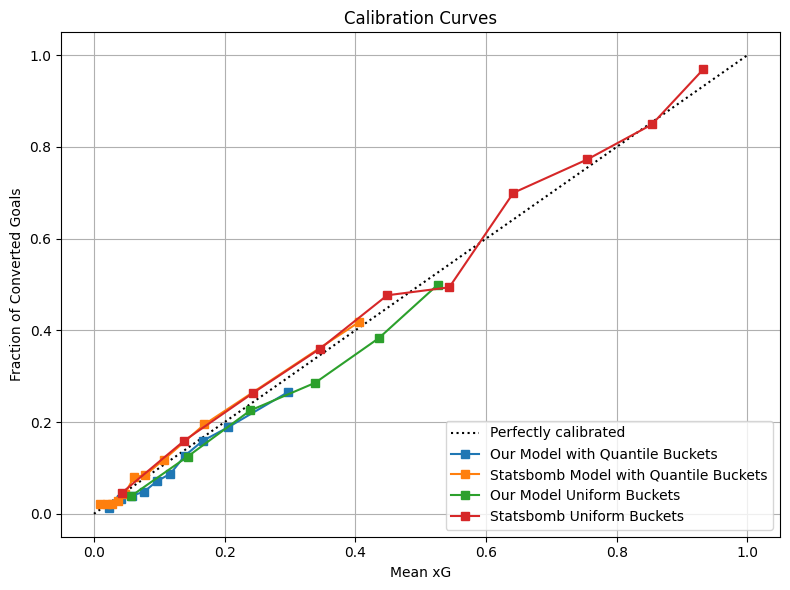

In [141]:
fig, ax = plt.subplots(figsize=(8, 6))

prob_true, prob_pred = calibration_curve(y_test, predictions_test, n_bins=10, strategy='quantile')
display_quantile = CalibrationDisplay(prob_true, prob_pred, y_test)
display_quantile.plot(ax=ax, name='Our Model with Quantile Buckets')

prob_true, prob_pred = calibration_curve(y_test, sbxg_test, n_bins=10, strategy='quantile')
display_quantile = CalibrationDisplay(prob_true, prob_pred, y_test)
display_quantile.plot(ax=ax, name='StatsBomb Model with Quantile Buckets')

prob_true, prob_pred = calibration_curve(y_test, predictions_test, n_bins=10)
display_uniform = CalibrationDisplay(prob_true, prob_pred, y_test)
display_uniform.plot(ax=ax, name='Our Model Uniform Buckets')

prob_true, prob_pred = calibration_curve(y_test, sbxg_test, n_bins=10)
display_uniform = CalibrationDisplay(prob_true, prob_pred, y_test)
display_uniform.plot(ax=ax, name='StatsBomb Uniform Buckets')

ax.grid()

plt.xlabel('Mean xG')
plt.ylabel('Fraction of Converted Goals')
plt.title('Calibration Curves')

plt.tight_layout()
plt.show()